In [7]:
import gym
import pickle

import tensorflow as tf
from tensorflow import keras
print(tf.test.gpu_device_name())

import cv2

import numpy as np
from collections import deque

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
import matplotlib.animation as animation
mpl.rc('animation', html='jshtml')

from pyglet.window import key
import time

In [8]:
env.seed(42)
np.random.seed(42)

In [9]:
class ObservationWrapper(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
    
    def observation(self, inputs):
        inputs = cv2.cvtColor(inputs, cv2.COLOR_BGR2GRAY)
        inputs = inputs.astype(float)
        inputs /= 255.0
        inputs = inputs[0:80, :]
        inputs = np.expand_dims(inputs, axis=-1)
        return inputs

In [10]:
def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

def render_policy_net(env, model, action_space, seed=42):
        frames = []
        env.seed(seed)
        np.random.seed(seed)
        obs = env.reset()
        negative_reward_counter=0
        for step in range(1000):
            frames.append(env.render(mode="rgb_array"))
            action_probas = model(obs[np.newaxis])
            print('action_probas', action_probas)
            p=tf.squeeze(action_probas).numpy()
            p /= np.sum(p)
            action = np.random.choice(range(5), p=p)
            print('action', action)
            obs, reward, done, info = env.step(action_space[action])
            if reward < 0:
                negative_reward_counter +=1
            else :
                negative_reward_counter = 0
            if done or negative_reward_counter > 75 :
                break
        env.close()
        return frames

## Deep Learning Model

In [16]:
x = keras.Input(shape=(96, 96, 1))
conv1 = keras.layers.Conv2D(filters=6, kernel_size=(8, 8), strides = 3, activation='relu')(x)
pool1 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)
conv2 = keras.layers.Conv2D(filters=12, kernel_size=(4, 4), activation='relu')(pool1)
pool2 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)
flatten = keras.layers.Flatten()(pool2)
dense1 = keras.layers.Dense(24, activation='relu')(flatten)
output_angle = keras.layers.Dense(1, activation='tanh')(dense1)
output_velocity_braking = keras.layers.Dense(2, activation='sigmoid')(dense1)
model = tf.keras.Model(x, [output_angle, output_velocity_braking])
model.summary()
#keras.layers.Dense(self.n_actions)])
keras.utils.plot_model(model, "my_model.png", show_shapes=True)

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 96, 96, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 30, 30, 6)    390         input_6[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_10 (MaxPooling2D) (None, 15, 15, 6)    0           conv2d_10[0][0]                  
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 12, 12, 12)   1164        max_pooling2d_10[0][0]           
____________________________________________________________________________________________

## Human Playing

In [11]:
class Trajectory :
    def __init__(self):
        super().__init__()
        self.frames = []
    
    def add_frame(self, state, action):
        frame = [state, action]
        self.frames.append(frame)
    
    def clear_frames(self):
        self.frames.clear()

In [12]:
class Imitation_Learning:
    def __init__(self,
        env,
        actions = np.array([0.0, 0.0, 0.0]),
        #action_space = [[-1,0,0],[0,0,0],[1,0,0],[0,1,0],[0,0,1]],                 
        n_frame_stack = 1,
        optimizer = keras.optimizers.Adam(lr=1e-2),
        loss_fn = keras.losses.categorical_crossentropy
    ):
        self.env             = env
        self.actions         = actions
        #self.action_space    = action_space
        #self.n_actions       = len(action_space)
        self.n_frame_stack   = n_frame_stack
        self.optimizer       = optimizer
        self.model           = self.build_model()
        self.loss_fn         = loss_fn
        self.do_not_quit     = True
        self.trajectory      = Trajectory()

    def build_model(self):
        x = keras.Input(shape=(96, 96, 1))
        conv1 = keras.layers.Conv2D(filters=6, kernel_size=(8, 8), activation='relu')(x)
        pool1 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)
        conv2 = keras.layers.Conv2D(filters=12, kernel_size=(4, 4), activation='relu')(pool1)
        pool2 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)
        flatten = keras.layers.Flatten()(pool2)
        dense1 = keras.layers.Dense(24, activation='relu')(flatten)
        output_angle = keras.layers.Dense(1, activation='tanh')(dense1)
        output_velocity_braking = keras.layers.Dense(2, activation='sigmoid')(dense1)
        model = tf.keras.Model(x, [output_angle, output_velocity_braking])
        #keras.layers.Dense(self.n_actions)])
        return model
    
    scores = []

    # arg 0 : steering angle (-1 to 1)
    # arg 1 : velocity (0 to 1)
    # arg 2 : braking (0 to 1)

    def press_key(self, k, mod):
        if k==0xff0d: restart = True
        if k==key.ESCAPE: self.do_not_quit=False
        if k==key.LEFT:  self.actions[0] = -0.5
        if k==key.RIGHT: self.actions[0] = +0.5
        if k==key.UP:    self.actions[1] = +0.6
        if k==key.DOWN:  self.actions[2] = +0.3

    def release_key(self, k, mod):
        if k==key.LEFT  and self.actions[0]<=-0.5: self.actions[0] = 0
        if k==key.RIGHT and self.actions[0]>=+0.5: self.actions[0] = 0
        if k==key.UP:    self.actions[1] = 0
        if k==key.DOWN:  self.actions[2] = 0

    def expert_play_carRacing(self, record_video=False):
        global restart
        scores = []

        self.env.reset()
        self.env.render()
        
        # to record it
        if record_video:
            self.env.monitor.start('/video', force=True)

        self.env.viewer.window.on_key_press = self.press_key
        self.env.viewer.window.on_key_release = self.release_key

        while self.do_not_quit:
            self.env.reset()
            total_reward = 0.0
            steps = 0
            restart = False
            t1 = time.time()  # Trial timer
            while self.do_not_quit:
                state, reward, done, info = self.env.step(self.actions)
                self.trajectory.add_frame(state, self.actions)
                # time.sleep(1/10)  # Slow down to 10fps for us poor little human!
                total_reward += reward
                if steps % 200 == 0 or done:
                    print("Step: {} | Reward: {:+0.2f}".format(steps, total_reward), "| Action:", self.actions)
                steps += 1
                if not record_video: # Faster, but you can as well call env.render() every time to play full window.
                    self.env.render()
                if done or restart or steps == 2000:
                    t1 = time.time()-t1
                    scores.append(total_reward)
                    print("Trial", len(scores), "| Score:", total_reward, '|', steps, "steps | %0.2fs."% t1)
                    break
            if not self.do_not_quit:
                scores.append(total_reward)
                #plt.imshow(state)
                print("Trial", len(scores), "| Score:", total_reward, '|', steps, "steps | %0.2fs."% t1)
        self.env.close()

In [13]:
env = gym.make('CarRacing-v0').env
w_env = ObservationWrapper(env)
IL_agent = Imitation_Learning(w_env)
IL_agent.expert_play_carRacing()

Track generation: 1103..1388 -> 285-tiles track
Track generation: 1251..1568 -> 317-tiles track
Step: 0 | Reward: +6.23 | Action: [0. 0. 0.]
Step: 200 | Reward: +65.34 | Action: [0. 0. 0.]
Step: 400 | Reward: +247.87 | Action: [0. 0. 0.]
Step: 600 | Reward: +405.09 | Action: [0. 0. 0.]
Step: 800 | Reward: +530.66 | Action: [0. 0. 0.]
Trial 1 | Score: 599.337974683534 | 937 steps | 1616783642.27s.


In [14]:
print(len(IL_agent.trajectory.frames))

937


In [30]:
env.close()

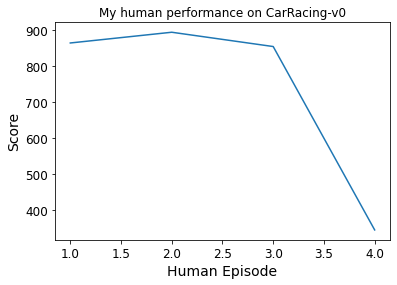

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.title('My human performance on CarRacing-v0')
plt.ylabel('Score')
plt.xlabel('Human Episode')
plt.show()